**Srayan Gangopadhyay**
*1st June 2020*

# Adding masked array

## Fix for periodic boundary conditions

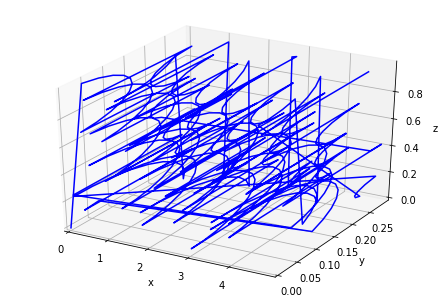

In [10]:
"""
Adding masked array (fix jumps)
Srayan Gangopadhyay
2020-05-27
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from celluloid import Camera  # easy animation module
from IPython.display import HTML  # to display in notebook

# PARAMETERS
r0 = [0, 0, 0]  # initial position
v0 = [1, 2, 0]  # initial velocity
B = [5, 0.02, 0.03]  # magnetic field
E = [0.1, 0.5, 0]  # electric field
q, m = 2, 0.7  # charge, mass
h = 0.02  # step size
end = 10  # t-value to stop integration
size = [5,0.3,1]  # simulation dimensions

def lorentz(vel):  # returns acceleration
    return (q/m)*(E+np.cross(vel, B))

# RUNGE-KUTTA INTEGRATOR
def rk4(func, init1, init2, h, end):
    """
    Takes the RHS of a 2nd-order ODE with initial conditions,
     step size and end point, and integrates using the 4th-order
     Runge-Kutta algorithm. Returns solution in an array.

     r'' = f(t, r, v) where v = r'

     func: the function to be integrated
     init1: value of r at t=0
     init2: value of v at t=0
     h: step size
     end: t-value to stop integrating
    """

    steps = int(end/h)  # number of steps
    r = np.zeros((3, steps))  # empty matrix for solution
    v = np.zeros((3, steps))
    r[:,0] = init1  # inserting initial value
    v[:,0] = init2

    for i in range(0, steps-1):
        k1r = h * v[:,i]
        k1v = h * func(v[:,i])
        k2r = h * (v[:,i] + 0.5*k1v)
        k2v = h * func(v[:,i] + 0.5*k1v)
        k3r = h * (v[:,i] + 0.5*k2v)
        k3v = h * func(v[:,i] + 0.5*k2v)
        k4r = h * (v[:,i] + k3v)
        k4v = h * func(v[:,i] + k3v)
        new_r = r[:,i] + (k1r + 2*k2r + 2*k3r + k4r) / 6
        new_v = v[:,i] + (k1v + 2*k2v + 2*k3v + k4v) / 6
        
        new_r[0] = new_r[0] % size[0]
        new_r[1] = new_r[1] % size[1]
        new_r[2] = new_r[2] % size[2]
            
        r[:,i+1] = new_r
        v[:,i+1] = new_v
    return r

r = rk4(lorentz, r0, v0, h, end)

r_abdif = np.abs(np.diff(r))  # abs. value of differences
# discard values more than 0.2 stand. dev. from mean
x_mask = np.hstack([r_abdif[0] > (r_abdif[0].mean() + 0.2 * r_abdif[0].std()), [False]])
y_mask = np.hstack([r_abdif[1] > (r_abdif[1].mean() + 0.2 * r_abdif[1].std()), [False]])
z_mask = np.hstack([r_abdif[2] > (r_abdif[2].mean() + 0.2 * r_abdif[2].std()), [False]])
# TODO: is there a way to do this more concisely?
# TODO: can we auto-adjust the number of stand. devs?
xr_masked = np.ma.MaskedArray(r[0], x_mask)
yr_masked = np.ma.MaskedArray(r[1], y_mask)
zr_masked = np.ma.MaskedArray(r[2], z_mask)

fig = plt.figure()
camera = Camera(fig)  # set up the 'camera' on the figure
ax = Axes3D(fig)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

for i in range(r.shape[1]):
    # plot data up to ith column and take snapshot
    ax.plot3D(xr_masked[:i], yr_masked[:i], zr_masked[:i], color='blue')
    camera.snap()

animation = camera.animate(interval=30, blit=True)
HTML(animation.to_html5_video())